## A/B compartment calling

This notebook demonstrates how to use ArcFISH to call A/B compartments from [Su et al, 2020](https://www.sciencedirect.com/science/article/pii/S0092867420309405?via%3Dihub). The subset used here can be downloaded from zenodo repository 3928890 with file name chromosome2_p-arm_replicate.tsv.

In [1]:
import matplotlib.pyplot as plt
import arcfish as af

Since the original file is not in FOF_CT-core format, we add two lines at the beginning of the file and convert it to a csv. The name of this new file is chromosome2_p-arm_replicate.csv.

Let's examine the file format by reading the first 5 lines to see the structure of the converted FOF_CT-core file.

In [2]:
with open("chromosome2_p-arm_replicate.csv", "r") as f:
    lines = "".join([f.readline() for _ in range(5)])
print(lines)

##Table_namespace=4dn_FOF-CT_core
##columns=(Spot_ID,Trace_ID,X,Y,Z,Chrom,Chrom_Start,Chrom_End)
0,1,26382.0,15407.0,4659.0,chr2,1,50001
1,1,26238.0,15347.0,3963.0,chr2,250001,300001
2,1,25270.0,15113.0,4220.0,chr2,500001,550001



## Load and preprocess the data

Create a FOF_CT_Loader object for the converted file and check which chromosomes are available.

In [3]:
loader = af.pp.FOF_CT_Loader("chromosome2_p-arm_replicate.csv", 
                             nm_ratio={c: 1000 for c in "XYZ"})
loader.chr_ids

array(['chr2'], dtype=object)

Load the data for chromosome 2 and subset to the first 100 cells for faster computation.

In [4]:
adata = loader.create_adata("chr2")
adata = adata[:100,:].copy()
adata

AnnData object with n_obs × n_vars = 100 × 357
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'

Calculate the median pairwise distance matrix, which will be stored in the `adata.varp` slot.

In [5]:
af.pp.median_pdist(adata, inplace=True)

Apply filtering and normalization to the data before compartment calling.

In [6]:
af.pp.filter_normalize(adata)

In [7]:
adata

AnnData object with n_obs × n_vars = 100 × 357
    var: 'Chrom_Start', 'Chrom_End'
    uns: 'Chrom'
    layers: 'X', 'Y', 'Z'
    varp: 'med_dist', 'raw_var_X', 'raw_var_Y', 'raw_var_Z', 'count_X', 'count_Y', 'count_Z', 'var_X', 'var_Y', 'var_Z'

## A/B compartment calling

Create an ABCaller object with minimum compartment size of 0 and run compartment calling on the processed data.

In [8]:
caller = af.tl.ABCaller(min_cpmt_size=0)
cpmt_result = caller.call_cpmt(adata)
cpmt_result.head()

,c1,s1,e1,cpmt,eig_x,eig_y,eig_z,wteig_x,wteig_y,wteig_z
0,chr2,1,50001,0,-0.064820,-0.050931,0.018169,-0.016317,-0.015034,0.008232
1,chr2,250001,300001,1,-0.015068,0.000185,0.013013,-0.003793,0.000055,0.005896
2,chr2,500001,550001,1,0.027947,0.061568,0.021069,0.007035,0.018174,0.009546
3,chr2,750001,800001,1,0.042551,0.016878,0.024852,0.010711,0.004982,0.011260
4,chr2,1000001,1050001,1,0.010925,0.039898,0.016105,0.002750,0.011777,0.007297


Visualize the results by creating a heatmap of the distance matrix with compartment bars overlaid to show the A/B compartment structure.

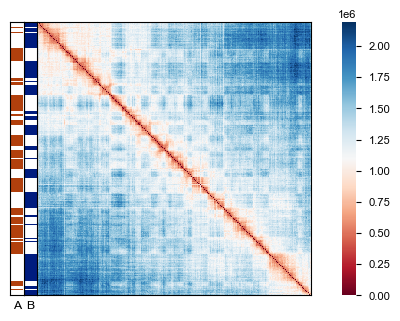

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
af.pl.pairwise_heatmap(adata.varp["med_dist"], ax=ax)
af.pl.cpmt_bars(cpmt_result["cpmt"], ax=ax)

## Computation speed up with dask

If on a computation cluster with multiple nodes, the computation can be sped up by distributing it to multiple nodes. This is possible since ArcFISH uses dask to do the computation in the background.

The following demonstrates how to do this on a SLURM computation cluster. For other cluster types, please refer to dask's [official documentation](https://jobqueue.dask.org/en/latest/clusters-api.html).

In [ ]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(
    queue="general",
    cores=10,
    memory="32 GB",
    log_directory="../log"
)
cluster.scale(jobs=20)
client = Client(cluster)

In [ ]:
adata = loader.create_adata("chr2")
af.pp.filter_normalize(adata)

In [ ]:
cluster.close()